In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from script_automation.automation_script_process_price import run_automation_process_price_data
from script_automation.automation_script_process_price_prueba import run_automation_process_price_data_prueba
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras
from keras.optimizers import Adam
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [4]:
df = pd.read_parquet('../../data_parquet/train_data.parquet')

In [ ]:
df_processed = run_automation_process_price_data(df) # Procesar datos

In [6]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156230 entries, 0 to 167999
Data columns (total 30 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   generation_fossil_gas                        156230 non-null  int64  
 1   generation_fossil_hard_coal                  156230 non-null  float64
 2   total_load_actual                            156230 non-null  int64  
 3   generation_nuclear                           156230 non-null  int64  
 4   generation_hydro_run_of_river_and_poundage   156230 non-null  float64
 5   generation_other_renewable                   156230 non-null  int64  
 6   generation_waste                             156230 non-null  float64
 7   generation_fossil_oil                        156230 non-null  int64  
 8   generation_other                             156230 non-null  int64  
 9   generation_hydro_water_reservoir             156230 non-null  fl

In [7]:
# Separar en variables dependiente y independiente
y = df_processed['price_actual'].values
df_processed.drop('price_actual', axis = 1, inplace=True)
X = df_processed

In [10]:
# Escalamos variables numericos
def standarize(X):
    numeric_columns = X.select_dtypes(include='number').drop(['day','hour'], axis = 1)
    scaler = MinMaxScaler()

    X[numeric_columns.columns] = scaler.fit_transform(numeric_columns)

    return X

In [11]:
X = standarize(X)

In [12]:
# Redimendion de los datos
X = np.reshape(X, (X.shape[0],X.shape[1], 1))

### Modelado

In [ ]:
# Red neuronal recurrente con capas LSTM
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
regressor.add(Dropout(0.5))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.5))
regressor.add(LSTM(units=100, return_sequences=False))
regressor.add(Dropout(0.5))
regressor.add(Dense(units=1))

In [ ]:
metrics=keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)
adam = Adam(learning_rate=0.0003)
regressor.compile(loss='mean_squared_error', optimizer=adam, metrics=[metrics])

In [ ]:
history = regressor.fit(X, y, epochs=40 ,batch_size=8) # entrenamiento

In [ ]:
# save the model
regressor.save('models_keras/model_price_v1.h5')

**Conjunto de prueba**

In [13]:
# carga del modelo guardado
model_price = keras.models.load_model('models_keras/model_price_v1.h5')

In [14]:
df_prueba = pd.read_parquet('../../data_parquet/test_data.parquet')

In [15]:
df_processed_prueba = run_automation_process_price_data_prueba(df_prueba) # Procesar datos

In [16]:
len(df_prueba)

10405

In [17]:
len(df_processed_prueba)

10405

In [18]:
# Separar en variables dependiente y independiente
y_test = df_processed_prueba['price_actual'].values
df_processed_prueba.drop('price_actual', axis = 1, inplace=True)
X_test = df_processed_prueba

In [19]:
X_test = standarize(X_test) # estandarizacion 

In [21]:
model_price.evaluate(X_test, y_test) # Validacion del modelo


326/326 [==============================] - 9s 19ms/step - loss: 11.5929 - root_mean_squared_error: 3.4048


[11.592889785766602, 3.4048333168029785]

In [22]:
pred_price_test = model_price.predict(X_test) # Prediccion 

326/326 [==============================] - 8s 19ms/step


In [23]:
y_test # datos reales

array([67.39, 66.31, 65.39, ..., 74.3 , 69.89, 69.88])

In [27]:
pred_price=pred_price_test.round(2) # prediccion del conjunto de datos reales (test)

In [28]:
pred_price

array([[10.98],
       [12.59],
       [42.13],
       ...,
       [77.69],
       [72.71],
       [73.68]], dtype=float32)

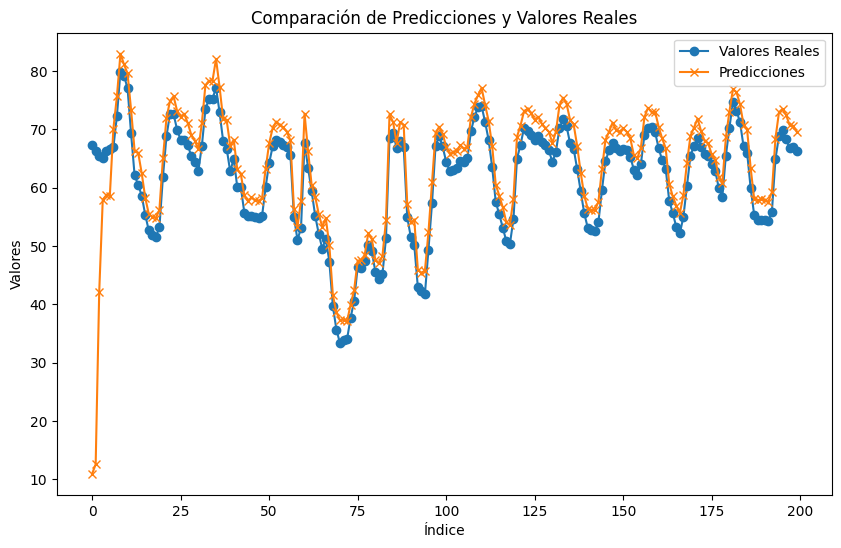

In [29]:
# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(y_test[:200], label='Valores Reales', marker='o')
plt.plot(pred_price[:200], label='Predicciones', marker='x')

plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Comparación de Predicciones y Valores Reales')
plt.legend()

plt.show()

In [30]:
# Metrica en conjunto de prueba (coeficiente de determinación)
r2 = r2_score(y_test, pred_price)
print('Score en conjunto de prueba:',round(r2,2))

Score en conjunto de prueba: 0.93


El modelo obtiene un error medio de 3.40€, explicando así en un 93% de las veces las predicciones sobre los valores reales.